<a href="https://colab.research.google.com/github/hsuanaush/113-2-GenAI/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

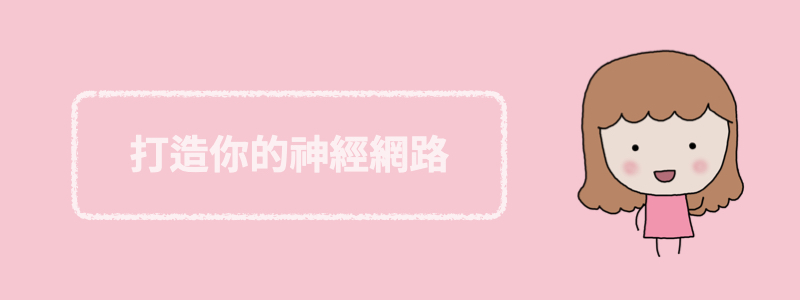

我們終於要開始做生命中第一個神經網路。要做的是 3 層深度學習架構  
1. 自行設定參數:
    - 每層神經元數量
    - learning rate
    - batch size
    - epochs
2. 選擇各層神經元數量
    - 第一層（輸入層）：MNIST 數據集是 28×28 的灰階圖片，通常會展平成 784 維的向量，所以 input_dim=784。

    - 隱藏層（Fully Connected Layers）：逐層減少神經元數，類似於金字塔結構（較常見，能有效學習特徵）。神經元數量一般設為 2^n（如 512、256、128、64），因為 GPU 運行時對這類數值優化較好。  
    - 輸出層：這是 10 個分類的 softmax 層，所以最後一層應該是 Dense(10, activation='softmax')。

In [3]:
N1 = 512
N2 = 256
N3 = 128
learning_rate=0.01
batch_size=300
epochs=30


## 1. 讀入套件

這裡我們讀入一些套件, 今天暫時不要理會細節。

In [6]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [7]:
%matplotlib inline

# 標準數據分析、畫圖套件
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 神經網路方面
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 互動設計用
from ipywidgets import interact_manual

# 神速打造 web app 的 Gradio
import gradio as gr

## 2. 讀入 MNIST 數據庫

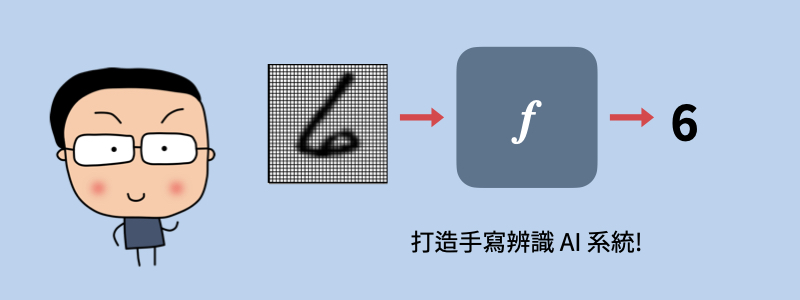

MNIST 是有一堆 0-9 的手寫數字圖庫。有 6 萬筆訓練資料, 1 萬筆測試資料。它是 "Modified" 版的 NIST 數據庫, 原來的版本有更多資料。這個 Modified 的版本是由 LeCun, Cortes, 及 Burges 等人做的。可以參考這個數據庫的[原始網頁](http://yann.lecun.com/exdb/mnist/)。

MNIST 可以說是 Deep Learning 最有名的範例, 它被 Deep Learning 大師 Hinton 稱為「機器學習的果蠅」。

### 由 Keras 讀入 MNIST、資料預處理

這段程式碼用於 載入 MNIST 數據集並進行前處理，使其適用於神經網路訓練：

1. 載入數據集

    - mnist.load_data() 讀取手寫數字資料集（MNIST），包含訓練集 60,000 張與測試集 10,000 張灰階圖片（28×28 像素）。
    - x_train 和 x_test：圖片數據（輸入特徵）。
    - y_train 和 y_test：標籤（對應 0~9 的數字）。
2. 數據預處理

    - x_train.reshape(60000, 784)/255：將圖片展平成 784 維向量（28×28 = 784），並進行 標準化（除以 255 讓像素值介於 0~1 之間），有助於神經網路更快收斂。
    - x_test.reshape(10000, 784)/255：同樣對測試數據進行轉換。
3. 標籤 One-Hot 編碼

    - to_categorical(y_train, 10)：將數字標籤（0~9）轉換為 One-Hot 向量（例如數字 3 → [0,0,0,1,0,0,0,0,0,0]），適用於分類模型的輸出。
    - to_categorical(y_test, 10)：同樣轉換測試標籤。

這樣處理後的 x_train 和 y_train 可用於訓練神經網路，x_test 和 y_test 可用於測試模型準確度。

In [17]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 784)/255
x_test = x_test.reshape(10000, 784)/255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## 3. 打造第一個神經網路

我們決定了我們的函數是

$$\hat{f} \colon \mathbb{R}^{784} \to \mathbb{R}^{10}$$

這個樣子。而我們又說第一次要用標準神網路試試, 所以我們只需要再決定要幾個隱藏層、每層要幾個神經元, 用哪個激發函數就可以了。

### 建構我們的神經網路

這段程式碼使用 Keras 建立一個全連接（Fully Connected）神經網路，適用於手寫數字識別（MNIST）等分類任務：

1. 模型架構（Sequential）

    - 第一層：全連接層（Dense），輸入 784 維（28×28 圖片攤平成一維），使用 ReLU 激活函數。
    - 第二、三層：隱藏層，神經元數量分別為 N2、N3，使用 ReLU 激活函數。
    - 輸出層：10 個神經元（對應 0~9 共 10 類），使用 softmax 進行分類。
2. 編譯模型
    - 損失函數：使用 categorical_crossentropy（適用於多類別分類）。
    - 優化器：SGD（隨機梯度下降），學習率 learning_rate，動量參數為 0.9。
    - 評估指標：使用準確率（accuracy）。  

這個模型適合作為基礎的多層感知機（MLP），用於影像分類或其他結構化數據的分類問題。

In [18]:
model = Sequential()
model.add(Dense(N1, input_dim=784, activation='relu'))
model.add(Dense(N2, activation='relu'))
model.add(Dense(N3, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=learning_rate, momentum=0.9), metrics=['accuracy'])

## 4. 檢視我們的神經網路

我們可以檢視我們神經網路的架構, 可以確認一下是不是和我們想像的一樣。

### 4.1 看 model 的 summary

In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

很快算算參數數目和我們想像是否是一樣的!

## 5. 訓練你的第一個神經網路

這行程式碼用於 訓練神經網路模型：

1. model.fit() 訓練模型

    - 輸入訓練資料：x_train（影像特徵）和 y_train（One-Hot 編碼標籤）。
    - batch_size=batch_size：設定 批次大小，每次更新權重時使用的樣本數量（影響訓練穩定性與效率）。
    - epochs=epochs：設定 訓練週期數，模型會遍歷整個訓練集 epochs 次。
2. 返回訓練歷史
    - history 會儲存訓練過程中的 損失值（loss） 和 準確率（accuracy），可用於畫圖分析模型表現。

這行程式碼執行後，模型會開始訓練，並根據設定的 批次大小與訓練週期數 來調整權重，使其逐步學習 MNIST 數據集的分類任務。

In [20]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6744 - loss: 1.1456
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9250 - loss: 0.2642
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9447 - loss: 0.1971
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9556 - loss: 0.1533
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9629 - loss: 0.1331
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9685 - loss: 0.1088
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9735 - loss: 0.0942
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9769 - loss: 0.0834
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9805 - loss: 0.0728
Epoch 10/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9832 - loss: 0.0608
Epoch 11/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9851 - loss: 0.0546
Epoch 12/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

## 畫出loss曲線

畫出loss曲線觀察訓練情況，以便後續調整模型

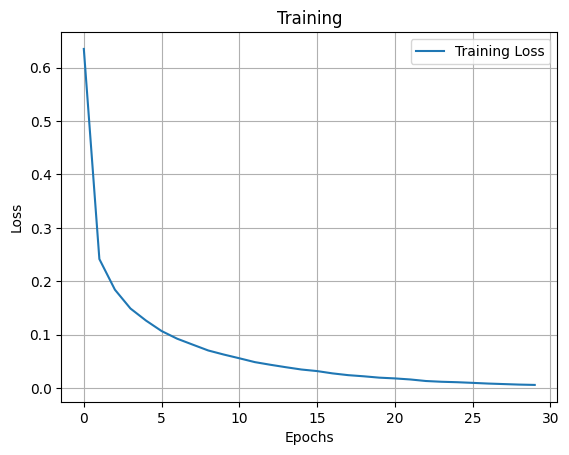

In [21]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training')
plt.legend()
plt.grid()
plt.show()

## 畫出training accuracy

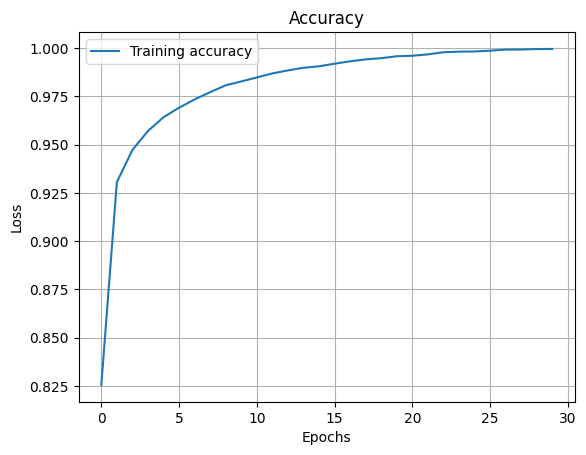

In [22]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.show()

## 6. 試用我們的結果

我們來用比較炫的方式來看看可愛的神經網路學習成果。對指令有問題可以參考《少年Py的大冒險：成為Python數據分析達人的第一門課》。

In [23]:
loss, acc = model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9769 - loss: 0.0823


In [ ]:
print(f"測試資料正確率 {acc*100:.2f}%")

測試資料正確率 98.08%


我們 "predict" 放的是我們神經網路的學習結果。做完之後用 argmax 找到數值最大的那一項。

In [24]:
predict = np.argmax(model.predict(x_test), axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
predict

array([7, 2, 1, ..., 4, 5, 6])

不要忘了我們的 `x_test` 每筆資料已經換成 784 維的向量, 我們要整型回 28x28 的矩陣才能當成圖形顯示出來!

In [ ]:
def test(測試編號):
    plt.imshow(x_test[測試編號].reshape(28,28), cmap='Greys')
    print('神經網路判斷為:', predict[測試編號])

In [ ]:
interact_manual(test, 測試編號=(0, 9999));

interactive(children=(IntSlider(value=4999, description='測試編號', max=9999), Button(description='Run Interact', …

到底測試資料總的狀況如何呢? 我們可以給我們神經網路「總評量」。

In [ ]:
score = model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9774 - loss: 0.0811


In [ ]:
print('loss:', score[0])
print('正確率', score[1])

loss: 0.06881653517484665
正確率 0.9807999730110168


### 7. 用 Gradio 來展示

In [ ]:
def resize_image(inp):
    # 圖在 inp["layers"][0]
    image = np.array(inp["layers"][0], dtype=np.float32)
    image = image.astype(np.uint8)

    # 轉成 PIL 格式
    image_pil = Image.fromarray(image)

    # Alpha 通道設為白色, 再把圖從 RGBA 轉成 RGB
    background = Image.new("RGB", image_pil.size, (255, 255, 255))
    background.paste(image_pil, mask=image_pil.split()[3]) # 把圖片粘貼到白色背景上，使用透明通道作為遮罩
    image_pil = background

    # 轉換為灰階圖像
    image_gray = image_pil.convert("L")

    # 將灰階圖像縮放到 28x28, 轉回 numpy array
    img_array = np.array(image_gray.resize((28, 28), resample=Image.LANCZOS))

    # 配合 MNIST 數據集
    img_array = 255 - img_array

    # 拉平並縮放
    img_array = img_array.reshape(1, 784) / 255.0

    return img_array

In [ ]:
def recognize_digit(inp):
    img_array = resize_image(inp)
    prediction = model.predict(img_array).flatten()
    labels = list('0123456789')
    return {labels[i]: float(prediction[i]) for i in range(10)}

In [ ]:
iface = gr.Interface(
    fn=recognize_digit,
    inputs=gr.Sketchpad(),
    outputs=gr.Label(num_top_classes=3),
    title="MNIST 手寫辨識",
    description="請在畫板上繪製數字"
)

iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a261d805cb66b6b025.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a261d805cb66b6b025.gradio.live
